In [1]:
!pip install numpy opencv-python scikit-image scikit-learn matplotlib

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu, threshold_sauvola
from sklearn.metrics import jaccard_score


In [2]:
root_dir = "/kaggle/input/brain-tumor-segmentation-dataset/Brain Tumor Segmentation Dataset"
image_root = os.path.join(root_dir, "image")
mask_root = os.path.join(root_dir, "mask")


In [3]:
def dice_score(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    return (2 * intersection) / (np.sum(y_true) + np.sum(y_pred) + 1e-8)

def compute_metrics(gt, pred):
    gt = gt.flatten()
    pred = pred.flatten()
    dice = dice_score(gt, pred)
    jaccard = jaccard_score(gt, pred)
    return dice, jaccard


In [4]:
def otsu_segmentation(image):
    t = threshold_otsu(image)
    return (image > t).astype(np.uint8)

def sauvola_segmentation(image):
    t = threshold_sauvola(image, window_size=25)
    return (image > t).astype(np.uint8)


In [5]:
otsu_dice=[]
otsu_jaccard=[]
sauvola_dice=[]
sauvola_jaccard=[]

sample_image=None
sample_mask=None
sample_otsu=None
sample_sauvola=None

for folder in os.listdir(image_root):

    image_folder=os.path.join(image_root,folder)
    mask_folder=os.path.join(mask_root,folder)

    if not os.path.isdir(image_folder):
        continue

    for filename in os.listdir(image_folder):

        img_path=os.path.join(image_folder,filename)
        name=os.path.splitext(filename)[0]
        mask_filename=name+"_m.jpg"
        mask_path=os.path.join(mask_folder,mask_filename)

        image=cv2.imread(img_path,0)
        mask=cv2.imread(mask_path,0)

        if image is None or mask is None:
            continue

        image=cv2.normalize(image,None,0,255,cv2.NORM_MINMAX)

        if image.shape!=mask.shape:
            mask=cv2.resize(mask,(image.shape[1],image.shape[0]))

        mask=(mask>127).astype(np.uint8)

        otsu_pred=otsu_segmentation(image)
        sauvola_pred=sauvola_segmentation(image)

        if sample_image is None:
            sample_image=image
            sample_mask=mask
            sample_otsu=otsu_pred
            sample_sauvola=sauvola_pred

        d_o,j_o=compute_metrics(mask,otsu_pred)
        d_s,j_s=compute_metrics(mask,sauvola_pred)

        otsu_dice.append(d_o)
        otsu_jaccard.append(j_o)
        sauvola_dice.append(d_s)
        sauvola_jaccard.append(j_s)


In [6]:
print("OTSU")
print("Average Dice:",np.mean(otsu_dice))
print("Average Jaccard:",np.mean(otsu_jaccard))

print("\nSAUVOLA")
print("Average Dice:",np.mean(sauvola_dice))
print("Average Jaccard:",np.mean(sauvola_jaccard))


OTSU
Average Dice: 0.04516398569068559
Average Jaccard: 0.02433014182174073

SAUVOLA
Average Dice: 0.028777029840554757
Average Jaccard: 0.01501374556877044


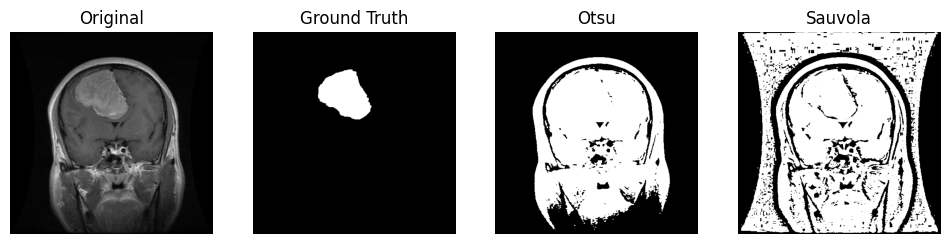

In [7]:
plt.figure(figsize=(12,4))

plt.subplot(1,4,1)
plt.imshow(sample_image,cmap='gray')
plt.title("Original")
plt.axis("off")

plt.subplot(1,4,2)
plt.imshow(sample_mask,cmap='gray')
plt.title("Ground Truth")
plt.axis("off")

plt.subplot(1,4,3)
plt.imshow(sample_otsu,cmap='gray')
plt.title("Otsu")
plt.axis("off")

plt.subplot(1,4,4)
plt.imshow(sample_sauvola,cmap='gray')
plt.title("Sauvola")
plt.axis("off")

plt.show()
